# Neutralization assays of Moderna and convalescent (HAARVI) sera versus WT and mutant spike-pseudotyped lentiviruses

Andrea, Lauren, and I set up these neuts.

The data that are analyzed in this notebook were pre-processed by Kate's `excel_to_fracinfect` script. 

### Import modules

In [55]:
import collections
import itertools
import math
import os
import re
import string
import warnings
import xml.etree.ElementTree as ElementTree

from IPython.display import display, HTML
from IPython.display import display, SVG
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import natsort
import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import yaml

In [56]:
warnings.simplefilter('ignore')

In [57]:
plt.style.use('seaborn-white')
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))

### Create results directory

In [58]:
resultsdir='results/mutant_neuts_results/'
os.makedirs(resultsdir, exist_ok=True)

Read config file

In [59]:
with open('mutant_neuts_config.yaml') as f:
    config = yaml.safe_load(f)

### Read in data
* Concatenate the `frac_infectivity` files.
* Remove samples specified in config file. 
* Also remove specified sample / dilution combinations where something has clearly gone wrong experimentally (like forgetting to add virus or cells). 
* Replace `serum` with `display_name`

In [60]:
frac_infect = pd.DataFrame() # create empty data frame

if config['neut_samples_ignore']:
    neut_samples_ignore = config['neut_samples_ignore']

for f in config['neut_input_files'].keys():
    df = (pd.read_csv(f, index_col=0).assign(date=config['neut_input_files'][f]))
    frac_infect = frac_infect.append(df).reset_index(drop=True)

print(f"Length before dropping anything = {len(frac_infect.index)}")
    
frac_infect = (frac_infect
        .reset_index(drop=True)
       )

print(f"Length after dropping neut_samples_ignore = {len(frac_infect.index)}")

# below deals with samples / dates/ dilutions to ignore, which are currently none

for virus in config['neut_ignore_viruses']:
    dat = config['neut_ignore_viruses'][virus]
    l = len((frac_infect[(frac_infect['virus'] == virus) & (frac_infect['date'] == dat)]))
    print(f"Dropping {l} rows")
    frac_infect = frac_infect.drop(frac_infect[((frac_infect['virus'] == virus) & (frac_infect['date'] == dat))].index)
    print(f"Length after dropping {virus}: {dat} = {len(frac_infect.index)}")


# change names .assign(wildtype=lambda x: x['site'].map(site_to_wt),    
print(config['validated_samples'])
    
frac_infect = frac_infect.assign(serum=lambda x: x['serum'].map(config['validated_samples']))
frac_infect.head(2)

Length before dropping anything = 1984
Length after dropping neut_samples_ignore = 1984
Dropping 128 rows
Length after dropping E484K: 210308 = 1856
{'M06-day-119': 'M06 (day 119)', 'M11-day-119': 'M11 (day 119)', 'M05-day-119': 'M05 (day 119)', 'M03-day-119': 'M03 (day 119)', 'M12-day-119': 'M12 (day 119)', 'M14-day-119': 'M14 (day 119)', '23_d120': 'subject A (day 120)', '1C_d113': 'subject B (day 113)', '24C_d104': 'subject C (day 104)', '22C_d104': 'subject E (day 104)', '25_d94': 'subject G (day 94)', '23C_d102': 'subject I (day 102)'}


,serum,virus,replicate,concentration,fraction infectivity,date
0,M03 (day 119),WT,1,0.04000,-0.000007,210308
1,M03 (day 119),WT,1,0.01333,-0.000007,210308


### Use `neutcurve` to fit Hill curves to data.
Get IC50 and calculate NT50. 
Determine if IC50 is bound.

In [61]:
for d in frac_infect['date'].unique():
    print(d)

210308
210312


In [62]:
fitparams = pd.DataFrame(columns=['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date'])

for d in frac_infect['date'].unique():
    fits = neutcurve.CurveFits(frac_infect.query('date==@d'))

    fp = (
        fits.fitParams()
        .assign(NT50=lambda x: 1/x['ic50'],
                date=d
               )
        .replace({'WT':'wildtype'})
        # get columns of interest
        [['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date']] 
        )

    # couldn't get lambda / conditional statement to work with assign, so try it here:
    fp['ic50_is_bound'] = fp['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)
    fitparams=fitparams.append(fp, ignore_index=True)

fitparams.head()

,serum,virus,ic50,NT50,ic50_bound,date,ic50_is_bound
0,M03 (day 119),wildtype,0.000561,1783.440839,interpolated,210308,False
1,M03 (day 119),E484P,0.003804,262.872902,interpolated,210308,False
2,M03 (day 119),G446V,0.000847,1180.832242,interpolated,210308,False
3,M03 (day 119),K417N,0.000555,1801.081391,interpolated,210308,False
4,M03 (day 119),K417N-G446V-E484K,0.002573,388.718850,interpolated,210308,False


### Calculate fold change for each mutant relative to wild type.

In [63]:
fc = (
    fitparams
#     .query('virus != "wildtype"')
#     .rename(columns={'virus': 'mutant'})
    .merge(fitparams.query('virus == "wildtype"')
                    [['serum', 'ic50', 'date']]
                    .rename(columns={'ic50': 'wildtype_ic50'}),
           on=['serum', 'date'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],
            log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2),
            sample_type=lambda x: x['serum'].map(config['sample_types'])
           )
    )

fc.to_csv(f'{resultsdir}/fitparams.csv', index=False)
fc.head(3)

,serum,virus,ic50,NT50,ic50_bound,date,ic50_is_bound,wildtype_ic50,fold_change,log2_fold_change,sample_type
0,M03 (day 119),wildtype,0.000561,1783.440839,interpolated,210308,False,0.000561,1.000000,0.000000,vaccine
1,M03 (day 119),E484P,0.003804,262.872902,interpolated,210308,False,0.000561,6.784423,2.762226,vaccine
2,M03 (day 119),G446V,0.000847,1180.832242,interpolated,210308,False,0.000561,1.510325,0.594859,vaccine


### Plot the raw neutralization curves

Saving to ./results/mutant_neuts_results//210308_mutant_neuts.pdf
Saving to ./results/mutant_neuts_results//210312_mutant_neuts.pdf


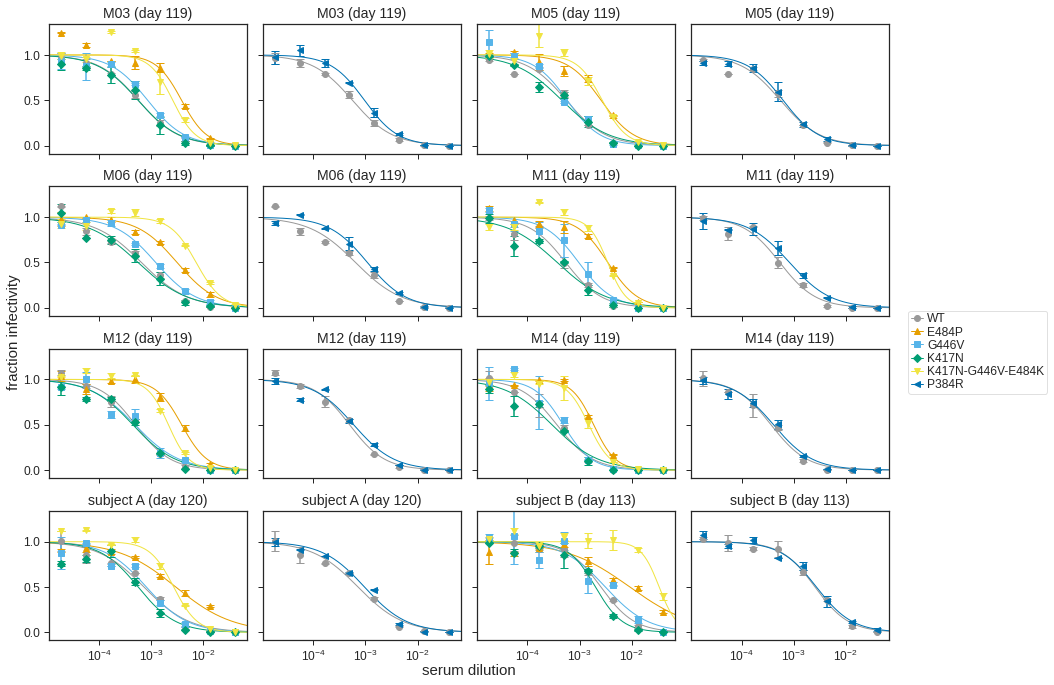

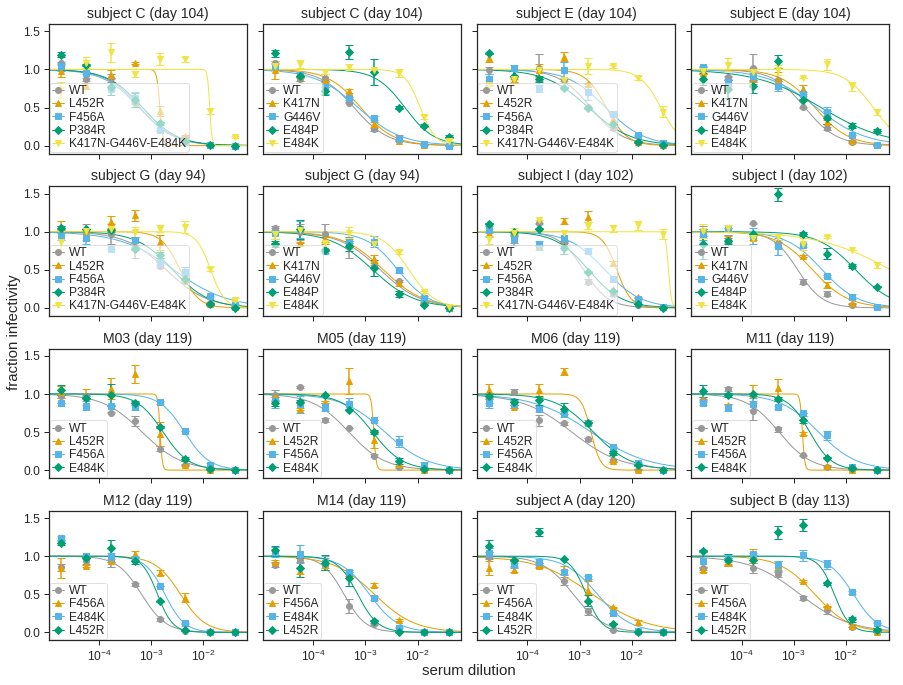

In [64]:
for d in frac_infect['date'].unique():
    fits = neutcurve.CurveFits(frac_infect.query('date==@d'))
    xlab= 'serum dilution'
    name= 'sera'

    fig, axes = fits.plotSera(xlabel=xlab,)

    plotfile = f'./{resultsdir}/{d}_mutant_neuts.pdf'
    print(f"Saving to {plotfile}")
    fig.savefig(plotfile, bbox_inches='tight')

## Get depletion NT50s and fold-change

In [65]:
haarvi_samples = config["validated_samples"].values()
haarvi_depletions = (pd.read_csv(config['haarvi_depletions'])
                     [['serum','fold_change', 'NT50_post', 'post-depletion_ic50', 'post_ic50_bound']]
                     .drop_duplicates()
                     .rename(columns={'NT50_post':'NT50', 
                                      'post-depletion_ic50':'ic50', 
                                      'post_ic50_bound':'ic50_is_bound'})
                     .assign(log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2),
                             virus='RBD antibodies depleted'
                            )
                     .query('serum in @haarvi_samples')
                    )

moderna_depletions = (pd.read_csv(config['moderna_depletions'])
                      [['serum','fold_change', 'NT50_post', 'post-depletion_ic50', 'post_ic50_bound']]
                      .drop_duplicates()
                      .rename(columns={'NT50_post':'NT50', 
                                      'post-depletion_ic50':'ic50', 
                                      'post_ic50_bound':'ic50_is_bound'})
                      .assign(log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2),
                              serum=lambda x: x['serum'].map(config['validated_samples']),
                              virus='RBD antibodies depleted'
                             )
                      .dropna(subset=['serum'])
                     )

depletion_df = (pd.concat([moderna_depletions, haarvi_depletions], axis=0, ignore_index=True)
               )
display(HTML(depletion_df.to_html(index=False)))

serum,fold_change,NT50,ic50,ic50_is_bound,log2_fold_change,virus
M03 (day 119),44.120772,25.000000,0.040000,True,5.463386,RBD antibodies depleted
M05 (day 119),70.659257,25.000000,0.040000,True,6.142807,RBD antibodies depleted
M06 (day 119),13.299399,72.471105,0.013799,False,3.733289,RBD antibodies depleted
M11 (day 119),51.592102,25.000000,0.040000,True,5.689078,RBD antibodies depleted
M12 (day 119),67.771270,25.000000,0.040000,True,6.082602,RBD antibodies depleted
M14 (day 119),52.573884,53.834278,0.018576,False,5.716274,RBD antibodies depleted
subject A (day 120),43.058197,20.000000,0.050000,True,5.428216,RBD antibodies depleted
subject B (day 113),14.243019,20.000000,0.050000,True,3.832183,RBD antibodies depleted
subject C (day 104),69.152358,20.000000,0.050000,True,6.111707,RBD antibodies depleted
subject E (day 104),35.318485,20.000000,0.050000,True,5.142352,RBD antibodies depleted


## Make plot showing NT50 for each genotype (wildtype or mutant) for each serum.
This is actually an important thing we should probably add to the paper. 
Even though the NT50s decrease by ~10-fold or more for some sera against some mutants, the absolute NT50 remaining might still be quite potent. 
It would be nice to have this clearly shown.

In [66]:
muts_depletions = (pd.concat([depletion_df, fc], axis=0, ignore_index=True)
                .assign(sample_type=lambda x: x['serum'].map(config['sample_types']),
                        virus=lambda x: pd.Categorical(x['virus'], categories=config['viruses'], ordered=True)
                       )
               )

display(HTML(muts_depletions.head().to_html(index=False)))

serum,fold_change,NT50,ic50,ic50_is_bound,log2_fold_change,virus,ic50_bound,date,wildtype_ic50,sample_type
M03 (day 119),44.120772,25.000000,0.040000,True,5.463386,RBD antibodies depleted,NaN,NaN,NaN,vaccine
M05 (day 119),70.659257,25.000000,0.040000,True,6.142807,RBD antibodies depleted,NaN,NaN,NaN,vaccine
M06 (day 119),13.299399,72.471105,0.013799,False,3.733289,RBD antibodies depleted,NaN,NaN,NaN,vaccine
M11 (day 119),51.592102,25.000000,0.040000,True,5.689078,RBD antibodies depleted,NaN,NaN,NaN,vaccine
M12 (day 119),67.771270,25.000000,0.040000,True,6.082602,RBD antibodies depleted,NaN,NaN,NaN,vaccine


In [67]:
muts_depletions['virus'].drop_duplicates()

0     RBD antibodies depleted
12                   wildtype
13                      E484P
14                      G446V
15                      K417N
16          K417N-G446V-E484K
17                      P384R
60                      L452R
61                      F456A
67                      E484K
Name: virus, dtype: category
Categories (10, object): ['wildtype' < 'P384R' < 'K417N' < 'F456A' ... 'E484K' < 'E484P' < 'K417N-G446V-E484K' < 'RBD antibodies depleted']

Saving to results/mutant_neuts_results//all_neuts_NT50.pdf


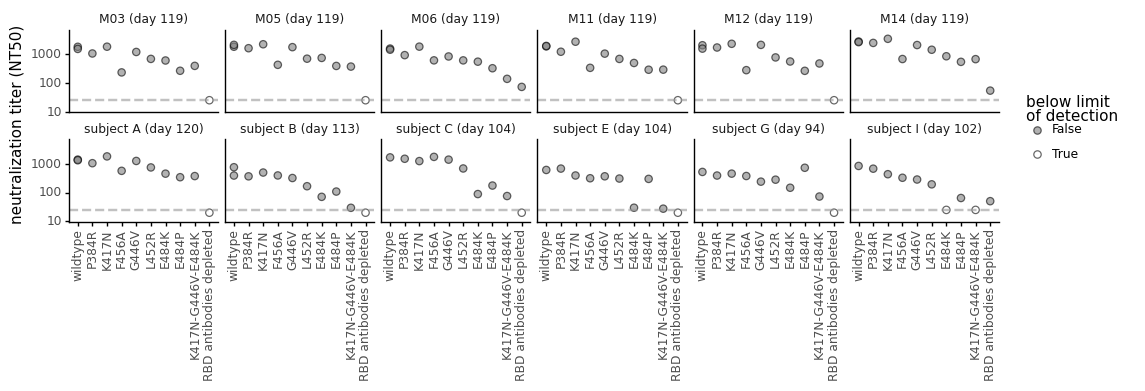

In [68]:
p = (ggplot((muts_depletions)) +
     aes('virus', 'NT50', fill='ic50_is_bound') +
     geom_point(size=2.5, alpha=0.6) +
     scale_x_discrete(name='') +
     scale_y_log10(name='neutralization titer (NT50)', expand=(0.1,0.1)) +
     facet_wrap('~serum', ncol=6) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.2 * muts_depletions['virus'].nunique()*muts_depletions['serum'].nunique()/2, 2.5),
           strip_margin_y=0.35,
           strip_background_x=element_blank(),
           ) +
         geom_hline(yintercept=25, linetype='dashed', size=1,
                    alpha=0.6, color=CBPALETTE[0]) +
     scale_fill_manual(values=['gray', 'white'],name='below limit\nof detection')
#          +scale_color_manual(values=['gray', '#D55E00'],name='E484 mutant')
     )

_ = p.draw()

plotfile = f'{resultsdir}/all_neuts_NT50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

### Plot fold-change IC50 relative to wild type for each mutant.
You could also imagine drawing a dashed line with the fold-change with RBD depletion, which sets an upper limit on what we would expect to see (the max drop in NT50 we could see due to anything RBD-related). 

To do this you would need to:
* Read in foldchange IC50 due to RBD depletion (specify path in config file)
* Merge with mutant `foldchange` dataframe
* Add `geom_hline` with depletion foldchange

Saving to results/mutant_neuts_results//fold_change_IC50.pdf


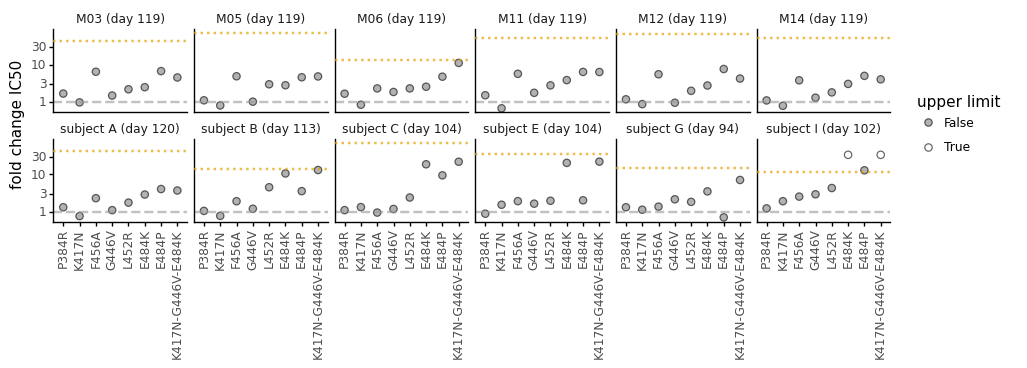

In [69]:
p = (ggplot(muts_depletions
            .query("virus != 'RBD antibodies depleted' & virus != 'wildtype'")
            ) +
     aes('virus', 'fold_change', fill='ic50_is_bound'
        ) +
     geom_point(size=2.5, alpha=0.6) +
     scale_y_log10(name='fold change IC50') +
     facet_wrap('~serum', ncol=6) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           axis_title_x=element_blank(),
           strip_margin_y=0.35,
           strip_background_x=element_blank(),
           figure_size=(0.2 * (muts_depletions['virus'].nunique()-1)*muts_depletions['serum'].nunique()/2, 2.5),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(data=muts_depletions.query('virus=="RBD antibodies depleted"'),
                mapping=aes(yintercept='fold_change'),
                color=CBPALETTE[1],
                alpha=0.7,
                size=1,
                linetype='dotted',
               ) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit') +
     scale_fill_manual(values=['gray', 'white'],name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

## Make nice plots of neut curves for paper
Make nice plots of all the neutralization curves for a paper figure:

In [70]:
def classify_serum_or_antibody(name):
    if name in config['serum_samples']:
        return 'serum'
    elif name in config['antibody_controls']:
        return 'antibody'
    else:
        raise ValueError(f"Cannot classify {name}")
        
def get_display_name(row):
    if row['serum_or_antibody'] == 'serum':
        return depletion_fc.set_index('sample_name')['display_name'].to_dict()[row['serum']]
    else:
        return 'antibody ' + row['serum']

frac_infect = (
    frac_infect
    .assign(serum_or_antibody=lambda x: x['serum'].map(classify_serum_or_antibody),
            display_name=lambda x: x.apply(get_display_name, axis=1),
            virus=lambda x: x['virus'].map(lambda s: 'wildtype' if s == 'WT' else s)
            )
    .sort_values('date')
    # https://stackoverflow.com/a/63890954
    .sort_values('display_name', key=lambda x: np.argsort(natsort.index_natsorted(x)))
    .assign(display_name_date=lambda x: x['display_name'] + '\n' + x['date'].astype(str) + ' assays')
    )

svgs = []
for group in ['serum', 'antibody']:
    print(f"\nMaking plot for {group}:")
    fits = neutcurve.CurveFits(frac_infect.query('serum_or_antibody == @group'),
                               serum_col='display_name_date')
    fig, axes = fits.plotSera(xlabel={'antibody': 'antibody concentration (ng/ml)',
                                      'serum': 'serum dilution'}[group],
                              ncol=8,
                              heightscale=1,
                              widthscale=0.88,
                              )
    plotfile = f'./{resultsdir}/{group}_mutant_neuts.svg'
    svgs.append(plotfile)
    print(f"Saving to {plotfile}")
    fig.savefig(plotfile, bbox_inches='tight')
    plt.close(fig)
    
merged_svg = os.path.join(resultsdir, 'mutant_neuts.svg')
print(f"\nCombining plots into {merged_svg}:")
panel_pad = 40
letter_height = 10
fig_svgs = []
fig_height = 0
for letter, svg in zip(string.ascii_uppercase, svgs):
    fig_height += panel_pad
    fig_svgs.append(svgutils.compose.Text(letter, 5, letter_height,
                                          font='Arial', size=22, weight='bold'
                                          ).move(0, fig_height)
                    )
    fig_height += letter_height
    fig_svgs.append(svgutils.compose.SVG(svg).move(0, fig_height))
    fig_height += svg_dim(svg, 'height')
svgutils.compose.Figure(max([svg_dim(svg, 'width') for svg in svgs]),
                        fig_height,
                        *fig_svgs,
                        ).save(merged_svg)
display(SVG(merged_svg))

KeyError: 'serum_samples'

Make plots of just key sera of interest.
For these, we specify which sera and viruses to show.
Then we plot just the **first** assay for each virus and sera in the final version, but first plot all assays and make sure wildtype is relatively consistent across assay dates:

In [ ]:
# key sera of interest
sera_to_plot = ['subject C (day 32)',
                'subject B (day 26)',
                'subject I (day 26)',
                'subject I (day 102)',
                'subject G (day 18)',
                'subject G (day 94)']
# key viruses of interest
viruses_to_plot = ['wildtype',
                   'G446V',
                   'E484K',
                   'E484Q',
                   'G485R',
                   ]

# plot curves for sera of interest with separate plot for each assay date
fits_by_date = neutcurve.CurveFits(frac_infect.query('(display_name in @sera_to_plot) and (virus in @viruses_to_plot)'),
                                   serum_col='display_name_date')
fig_by_date, _ = fits_by_date.plotSera(xlabel='serum dilution',
                                       ncol=5,
                                       heightscale=1,
                                       widthscale=0.9,
                                       )
display(fig_by_date)
plt.close(fig_by_date)

# tabulate IC50s of wildtype on each assay date
(display(
    frac_infect
    [['display_name_date', 'display_name', 'date']]
    .drop_duplicates()
    .rename(columns={'display_name_date': 'serum'})
    .merge(fits_by_date.fitParams(), how='right')
    .drop(columns='serum')
    .sort_values(['display_name', 'virus', 'date'])
    .query('virus == "wildtype"')
    ))

# Now plot by sera **not** including assay date; when multiple measurements for
# an assay date just take the first one.
df = (frac_infect
      .query('(display_name in @sera_to_plot) and (virus in @viruses_to_plot)')
      .assign(first_assay_date=lambda x: x.groupby(['display_name', 'virus'])['date'].transform('first'))
      .query('date == first_assay_date')
      )
fits = neutcurve.CurveFits(df,
                           serum_col='display_name')
fig, _ = fits.plotSera(xlabel='serum dilution',
                       ncol=2,
                       heightscale=0.95,
                       widthscale=1.25,
                       max_viruses_per_subplot=len(viruses_to_plot),
                       sharex=True,
                       )
display(fig)
main_fig_neut_svg = os.path.join(resultsdir, 'main_fig_neut.svg')
print(f"Saving to {main_fig_neut_svg}")
fig.savefig(main_fig_neut_svg, bbox_inches='tight')
plt.close(fig)

## Make plots with escape fractions and fold-change IC50.

Define general function for making violin plots of escape combined with fold-change IC50s for all sera:

In [ ]:
def day_labeller(old_label):
    new_label = f'day {old_label}'
    return(new_label)

def accessible_down(mutant):
    """Is mutation accessible in down conformation?"""
    if re.search('446|484|485|494', mutant):
        return 'yes'
    elif re.search('384|456', mutant):
        return 'no'
    else:
        raise ValueError(f"no up/down accessibility info for {mutant}")
        
show_legend_subjects = ['subject B']

def make_escape_and_ic50_plot(escape_metric,
                              output_svg,
                              escape_ymax,
                              ylabel,
                              ):
    svgs = {'main_fig_neuts': main_fig_neut_svg}
    for subject, subj_df in foldchange.query('sample_group == "serum"').groupby('display_PID'):
    
        ic50s = subj_df[['serum', 'mutant', 'fold_change']]
    
        subject_df = (subj_df[['serum', 'depletion_fc', 
                               'sample', 'Participant ID', 'Days Post-Symptom Onset',
                               'sample_name', 'display_PID', 'display_name',
                               ]]
                      .drop_duplicates()
                      .assign(day=lambda x: x['Days Post-Symptom Onset'].astype(int))
                      )
        if isinstance(escape_ymax, dict):
            violin_ymax = max([escape_ymax[display_name]
                               for display_name in subject_df['display_name'].unique()])
        else:
            violin_ymax = escape_ymax
    
        # get escape fracs for this subject dealing with fact that selections
        # have additional underscore giving concentration
        serum_to_selection = {}
        for serum in subject_df['serum'].tolist():
            selection = [s for s in escape_fracs['selection'].unique() if re.fullmatch(f"{serum}_\d+", s)]
            assert len(selection) == 1, f"for serum {serum} did not find 1 selection:\n{selection}"
            serum_to_selection[serum] = selection[0]
    
        # get data frame with escape fractions for just this subject, indicating which mutations
        # have fold change IC50
        df = (subject_df
              .assign(selection=lambda x: x['serum'].map(serum_to_selection))
              .merge(escape_fracs,
                     how='left', on='selection', validate='one_to_many')
              .assign(mutant=lambda x: x['wildtype'] + x['label_site'].astype(str) + x['mutation'],
                      site_label=lambda x: x['wildtype'] + x['label_site'].astype(str),
                      )
              .merge(ic50s, how='left', on=['serum', 'mutant'], validate='one_to_one')
              .assign(day=lambda x: pd.Categorical(x['Days Post-Symptom Onset'], 
                                                   natsort.natsorted(x['day'].unique()), 
                                                   ordered=True),
                     )
              )
        
        # data frame with mutations with fold changes for this subject
        df_foldchange = (
            df
            .query('fold_change.notnull()')
            .sort_values('site')
            .assign(mutant=lambda x: pd.Categorical(x['mutant'], x['mutant'].unique(), ordered=True),
                    accessible_down=lambda x: pd.Categorical(x['mutant'].map(accessible_down),
                                                             ['no', 'yes'],
                                                             ordered=True)
                    )
            )
           
        if 'mut' in escape_metric:
            ptlabel = 'mutant'
        else:
            assert 'site' in escape_metric
            ptlabel = 'site_label'
            df = df[['display_PID', 'day', escape_metric, ptlabel]].drop_duplicates()

        # make violin plot
        violin = (ggplot(df) +
                  aes('day', escape_metric) +
                  geom_violin(color='gray', fill='gray', alpha=0.5, adjust=5) +
                  geom_jitter(data=df_foldchange[['day', escape_metric, ptlabel, 'accessible_down']].drop_duplicates(),
                              mapping=aes(color='accessible_down', shape='accessible_down'),
                              size=2,
                              height=0,
                              width=0.1,
                              alpha=1,
                              random_state=1,
                              ) +
                  geom_text(data=df_foldchange[['day', escape_metric, ptlabel, 'accessible_down']].drop_duplicates(),
                            mapping=aes(label=ptlabel, color='accessible_down'),
                            size=8,
                            adjust_text={'expand_points': (1.05, 1.1),
                                         'expand_text': (1.05, 1.2),
                                         }
                            ) +
                  expand_limits(y=(0, violin_ymax)) +
                  theme_matplotlib() +
                  theme(figure_size=(1.2 * df['day'].nunique(), 2.0),
                        strip_background=element_blank(),
                        axis_text_x=element_blank(),
                        axis_ticks_major_x=element_blank(),
                        legend_position='none',
                        axis_title_x=element_blank(),
                        ) +
                  scale_y_continuous(name=ylabel, 
                                     expand=(0.075, 0)) +
                  facet_wrap('~ day', scales='free_x', labeller=day_labeller) +
                  scale_color_manual(values=[CBPALETTE[5], CBPALETTE[6]], drop=False) +
                  scale_shape_manual(values=['^', 'o'], drop=False)
                  )
        violin_svg = os.path.join(resultsdir, f"{subject.replace(' ', '_')}_violin_{escape_metric}.svg")
        violin.save(violin_svg, verbose=False)
    
        # make foldchange plot
        fc_df = (
            df_foldchange
            [['mutant', 'fold_change', 'day', 'depletion_fc']]
            .merge(ic50s[['mutant', 'fold_change', 'serum']]
                        .merge(df_foldchange[['serum', 'day', 'depletion_fc']].drop_duplicates()),
                   how='outer'
                   )
            .assign(accessible_down=lambda x: pd.Categorical(x['mutant'].map(accessible_down),
                                                             ['no', 'yes'],
                                                             ordered=True))
            )
        fc = (ggplot(fc_df) +
              aes('mutant', 'fold_change', color='accessible_down', shape='accessible_down') +
              geom_point(size=2) +
              theme_matplotlib() +
              theme(figure_size=(0.4 * len(df_foldchange), 1.8),
                    axis_text_x=element_text(angle=90, size=9),
                    strip_background=element_blank(),
                    axis_title_x=element_blank(),
                    ) +
              expand_limits(y=(0.5, 100)) +
              scale_y_log10(name='fold change IC50') +
              geom_hline(yintercept=1, color='gray', linetype='dashed', size=1, alpha=0.5) +
              geom_hline(aes(yintercept='depletion_fc'),
                         color=CBPALETTE[1],
                         alpha=0.7,
                         size=1,
                         linetype='dotted',
                         ) +
              facet_wrap('~ day', scales='free_x', labeller=day_labeller)  +
              scale_color_manual(values=[CBPALETTE[5], CBPALETTE[6]], drop=False,
                                 name='accessible\nin down RBD') +
              scale_shape_manual(values=['^', 'o'], drop=False,
                                 name='accessible\nin down RBD')
              )
        if subject not in show_legend_subjects:
            fc = (fc +
                  theme(legend_position='none',
                        legend_margin=0,
                        legend_box_margin=0,
                        )
                  )
        
        fc_svg = os.path.join(resultsdir, f"{subject.replace(' ', '_')}_fc_{escape_metric}.svg")
        fc.save(fc_svg, verbose=False)
    
        # assemble into a panel for this subject
        horiz_pad = 6
        title_pad = 5
        svg = os.path.join(resultsdir, f"{subject.replace(' ', '_')}.svg")
        width = svg_dim(violin_svg, 'width') + horiz_pad + svg_dim(fc_svg, 'width')
        svgutils.compose.Figure(
                width,
                max(svg_dim(violin_svg, 'height'), svg_dim(fc_svg, 'height')) + title_pad,
                svgutils.compose.Text(subject, width / 2 - horiz_pad, title_pad / 2, font='Arial', size=12),
                svgutils.compose.SVG(violin_svg).move(0, title_pad),
                svgutils.compose.SVG(fc_svg).move(svg_dim(violin_svg, 'width') + horiz_pad, title_pad)
                ).save(svg)
        svgs[subject] = svg
        
    # assemble into final SVG
    layout = [
        [('A', 'Mutations at 484 can have large effects on neutralization.'),
         'subject C',
         'subject B',
         ('B', 'Mutations at 446, 485, and 494 can also affect neutralization.'),
         'subject I',
         'subject E',
         'subject G',
         ],
        [('C', 'Some sera are unaffected by any single mutation.'),
         'subject J',
         'subject K',
         'subject A',
         ('D', 'Neutralization curves for key sera / mutations.'),
         'main_fig_neuts',
         ],
        ]
    scale_panels = collections.defaultdict(lambda: 1)
    scale_panels['main_fig_neuts'] = 0.73
    fig_svgs = []  # build up this list of `svgutils.compose.SVG` objects
    fig_height = fig_width = 0
    height_pad = 20
    width_pad = 17
    for icol, col_list in enumerate(layout):
        col_height = 0
        col_width = 0
        for panel in col_list:
            if panel in svgs:
                svg = svgs.pop(panel)
                width = svg_dim(svg, 'width') * scale_panels[panel]
                height = svg_dim(svg, 'height') * scale_panels[panel]
                fig_svgs.append(svgutils.compose.SVG(svg).scale(scale_panels[panel]).move(fig_width, col_height))
                col_height += height + height_pad
                col_width = max(col_width, width)
            else:
                (letter, title) = panel
                col_height += 18  # margin between vertical lettered panels
                fig_svgs.append(svgutils.compose.Text(letter, fig_width + 10, col_height,
                                                      font='Arial', size=16, weight='bold'))
                fig_svgs.append(svgutils.compose.Text(title, fig_width + 40, col_height,
                                                      font='Arial', size=14, weight='italic'))
                col_height += 16  # height of text
        fig_height = max(fig_height, col_height)
        fig_width += col_width + width_pad
    assert len(svgs) == 0, ValueError(f"still have some SVGs: {svgs}")
    svgutils.compose.Figure(fig_width, fig_height, *fig_svgs).save(output_svg)

Make the mutation-level plot:

In [ ]:
mut_fig_svg = os.path.join(resultsdir, 'validation_fig_mut.svg')
make_escape_and_ic50_plot(escape_metric='mut_escape_frac_epistasis_model',
                          output_svg=mut_fig_svg,
                          escape_ymax=0.4,
                          ylabel='escape fraction',
                          )
display(SVG(mut_fig_svg))

Make the site-level plot (total escape at site):

In [ ]:
sitetotal_fig_svg = os.path.join(resultsdir, 'validation_fig_sitetotal.svg')
make_escape_and_ic50_plot(escape_metric='site_total_escape_frac_epistasis_model',
                          output_svg=sitetotal_fig_svg,
                          escape_ymax=(pd.read_csv(config['ylim_file'])
                                       .set_index('condition')['maximum'].to_dict()
                                       ),
                          ylabel='total escape at site',
                          )
display(SVG(sitetotal_fig_svg))

In [ ]:
!jupyter nbconvert mutant_neuts.ipynb --to markdown